**Author:** Raoul Malm

**Abstract:** 

Given are a training and test data set where each entry contains 80 features that are related to house properties. For the training set which has 4160 entries we know the actual sale prices for each house. The goal is to predict the unknown sale prices for the 4159 entries of the test set. This is a supervised regression problem. After analyzing the data we correct, convert, delete and create new features. We check the correlation of the features and their importance on the sale price. After the feature selection we model the data and try single and ensembles of models. Finally we predict and submit the test results. The precision of each model is evaluated by the root-mean-squared error (rmse) of the logarithm of the sale prices.

**Results:** 

- When we use single (base) models trained with 10-fold cross-valdidation we can achieve an average root-mean-squared error of about 0.124 on the validation set. Lasso regression gives very good results.

- We can stack different base models and train a meta-model on their out-of-fold predictions. Combining Lasso regression and gboost regression achieves a root-mean-squared error of 0.11710 on the test set.

- We also implement a simple neural network but it underperforms with respect to the other base models.


**Outline:**

1. [Libraries and settings](#1-bullet)  
2. [Analyze and manipulate data](#2-bullet)  
2.1 [First look](#2.1-bullet)  
2.2 [Target feature SalePrice](#2.2-bullet)  
2.3 [Correct missing data](#2.3-bullet)  
2.4 [Convert and create new features](#2.4-bullet)  
2.5 [Check correlation of features](#2.5-bullet)  
2.6 [Final feature selection](#2.6-bullet)  
3. [Model and validate data](#3-bullet)    
3.1 [Split training/validation/test data](#3.1-bullet)   
3.2 [Neural network implementation](#3.2-bullet)  
3.3 [Base models and model averaging](#3.3-bullet)     
3.4 [Stacking of models and meta model prediction](#3.4-bullet)    
4. [Predict and submit test results](#4-bullet)    

**References:**

[Stacked Regressions : Top 4% on LeaderBoard by Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

[Comprehensive data exploration with Python by Pedro Marcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a>

In [1]:
import numpy as np  
import pandas as pd  
import scipy.stats   
import scipy.special  
import subprocess
import sklearn.linear_model
import sklearn.model_selection
import sklearn.pipeline  
import sklearn.preprocessing  
import sklearn.ensemble  
import sklearn.kernel_ridge 
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# check the files available in the directory
print(subprocess.check_output(["ls", "../input"]).decode("utf8")) 

sample_submission.csv.gz
test.csv
train.csv



# 2. Analyze and manipulate data <a class="anchor" id="2-bullet"></a>

### 2.1 First look  <a class="anchor" id="2.1-bullet"></a>

In [2]:
## import train and test data

train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

print('train_df.shape = ', train_df.shape)
print('test_df.shape = ', test_df.shape)

train_df.shape =  (1460, 81)
test_df.shape =  (1459, 80)


In [3]:
## show all features

num_of_numerical_cols = train_df._get_numeric_data().columns.shape[0]
print(num_of_numerical_cols, 'numerical columns')
print(train_df.shape[1]-num_of_numerical_cols, 'categorial columns')
train_df.columns.values

38 numerical columns
43 categorial columns


array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

In [4]:
#train_df.info()

In [5]:
#test_df.info()

In [6]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### 2.2 Target feature SalePrice  <a class="anchor" id="2.2-bullet"></a>

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
mu = 180921.20 and sigma = 79415.29
Skewness: 1.882876
Kurtosis: 6.536282


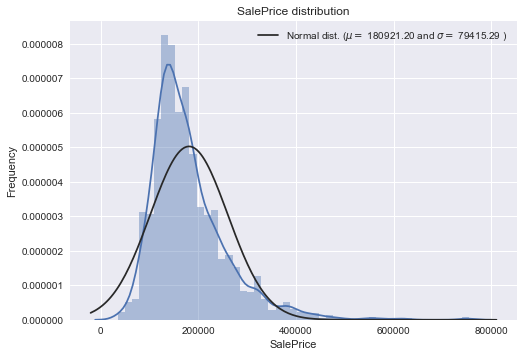

In [8]:
## Analyze SalePrice

print(train_df['SalePrice'].describe())

sns.distplot(train_df['SalePrice'], fit=scipy.stats.norm);

# fit a gaussian function to SalePrice
(mu, sigma) = scipy.stats.norm.fit(train_df['SalePrice'])

# mean, std, skewness and kurtosis
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

# plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

mu = 180921.20 and sigma = 79415.29
Skewness: 0.121347
Kurtosis: 0.809519


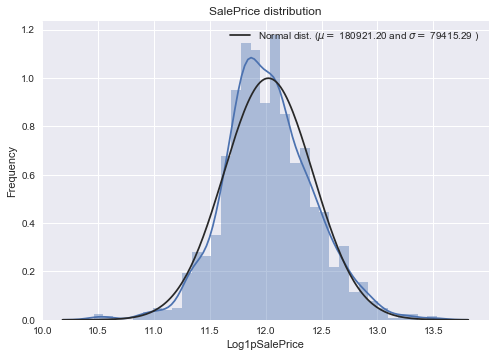

In [9]:
## create feature Log1pSalePrice = log(1+SalePrice)

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["Log1pSalePrice"] = np.log1p(train_df["SalePrice"])

#Check the new distribution 
sns.distplot(train_df['Log1pSalePrice'] , fit=scipy.stats.norm);
(mu, sigma) = scipy.stats.norm.fit(train_df['SalePrice'])

# mean, std, skewness and kurtosis
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
print("Skewness: %f" % train_df['Log1pSalePrice'].skew())
print("Kurtosis: %f" % train_df['Log1pSalePrice'].kurt())

# plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

### 2.3 Correct missing data  <a class="anchor" id="2.3-bullet"></a>

In [14]:
## concatenate train and test data
data_df = pd.concat((train_df, test_df)).reset_index(drop=True)
data_df.drop(['SalePrice','Log1pSalePrice'], axis=1, inplace=True)
print("data_df.shape = ",data_df.shape)

ValueError: labels ['SalePrice' 'Log1pSalePrice'] not contained in axis

In [ ]:
## check missing data

data_df_na = data_df.isnull().mean(axis=0)
data_df_na = data_df_na.drop(data_df_na[data_df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Data Ratio': data_df_na})
print('data_df_na.shape = ', data_df_na.shape)
missing_data.head(20)

In [ ]:
## visualize missing data

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x = data_df_na.index, y = 100*data_df_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percentage of missing values', fontsize=15)
plt.title('Percentage of missing data of features', fontsize=15)

In [ ]:
## treat missing values

# set missing values to None (which means that the house does not have those features)
data_df["PoolQC"] = data_df["PoolQC"].fillna("None") # has no pool
data_df["MiscFeature"] = data_df["MiscFeature"].fillna("None") # has no special feature 
data_df["Alley"] = data_df["Alley"].fillna("None") # has no alley access
data_df["Fence"] = data_df["Fence"].fillna("None") # has no fence 
data_df["FireplaceQu"] = data_df["FireplaceQu"].fillna("None") # has no fireplace

# group by neighborhoods and set missing values to 
# the median of LotFrontage of the corresponding neighborhoods
data_df["LotFrontage"] = data_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# no garage => set missing entries to None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data_df[col] = data_df[col].fillna('None')

# no garage => set missing entries to 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data_df[col] = data_df[col].fillna(0)

# having no basement => set missing entries to 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 
            'BsmtHalfBath'):
    data_df[col] = data_df[col].fillna(0)
    
# having no basement => set missing entries to None
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data_df[col] = data_df[col].fillna('None')
    
# no masonry veneer => set Area = 0 and Type = None
data_df["MasVnrType"] = data_df["MasVnrType"].fillna("None")
data_df["MasVnrArea"] = data_df["MasVnrArea"].fillna(0)

# general zoning classification: set missing entry to most common value
data_df['MSZoning'] = data_df['MSZoning'].fillna(data_df['MSZoning'].mode()[0])

# for this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA
# => we can remove it
data_df = data_df.drop(['Utilities'], axis=1)

# set missing value to typical
data_df["Functional"] = data_df["Functional"].fillna("Typ")

# set missing entries to most common values
data_df['Electrical'] = data_df['Electrical'].fillna(data_df['Electrical'].mode()[0])
data_df['KitchenQual'] = data_df['KitchenQual'].fillna(data_df['KitchenQual'].mode()[0])
data_df['Exterior1st'] = data_df['Exterior1st'].fillna(data_df['Exterior1st'].mode()[0])
data_df['Exterior2nd'] = data_df['Exterior2nd'].fillna(data_df['Exterior2nd'].mode()[0])
data_df['SaleType'] = data_df['SaleType'].fillna(data_df['SaleType'].mode()[0])

# set missing value to None 
data_df['MSSubClass'] = data_df['MSSubClass'].fillna("None")

In [ ]:
## check if missing values remain

data_df_na = data_df.isnull().median(axis = 0)
data_df_na = data_df_na.drop(data_df_na[data_df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Data Ratio': data_df_na})
print('data_df_na.shape = ', data_df_na.shape)
missing_data.head()

### 2.4 Convert and create new features  <a class="anchor" id="2.4-bullet"></a>

In [ ]:
## Convert numerical type into string type for categorial features 

# MSSubClass = The building class
data_df['MSSubClass'] = data_df['MSSubClass'].apply(str)

# changing OverallCond into a categorical variable
data_df['OverallCond'] = data_df['OverallCond'].astype(str)

# year and month sold are transformed into categorical features
data_df['YrSold'] = data_df['YrSold'].astype(str)
data_df['MoSold'] = data_df['MoSold'].astype(str)

In [ ]:
## Encode some features with values between 0 and n_classes-1

# categorial features
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# apply sklearn.preprocessing.LabelEncoder to each categorical feature
for c in cols:
    lbl = sklearn.preprocessing.LabelEncoder() 
    lbl.fit(list(data_df[c].values)) 
    data_df[c] = lbl.transform(list(data_df[c].values))

# shape        
print('data_df.shape = ', data_df.shape)

In [ ]:
## Create new feature: total sqfootage 

data_df['TotalSF'] = data_df['TotalBsmtSF'] + data_df['1stFlrSF'] + data_df['2ndFlrSF']


In [ ]:
## Check the skewness of all numerical features

numerical_features = data_df.dtypes[data_df.dtypes != "object"].index
skewness_of_features = data_df[numerical_features].apply(lambda x: scipy.stats.skew(x.dropna())).sort_values(
    ascending=False)
skewness_df = pd.DataFrame({'Skewness': skewness_of_features})
skewness_df.head(10)

In [ ]:
## Compute the Box-Cox transformation of 1 + x for skewed features

skewness_df = skewness_df[abs(skewness_df) > 0.75]
print("skewness_df.shape = ", skewness_df.shape)
skewed_features = skewness_df.index
lamb = 0.15
for feature in skewed_features:
    data_df[feature] = scipy.special.boxcox1p(data_df[feature], lamb)

In [ ]:
## Check skewness again

numerical_features = data_df.dtypes[data_df.dtypes != "object"].index
skewness_of_features = data_df[numerical_features].apply(lambda x: 
                            scipy.stats.skew(x.dropna())).sort_values(ascending=False)
skewness_df = pd.DataFrame({'Skewness': skewness_of_features})
skewness_df.head(10)

### 2.5 Check correlation of features  <a class="anchor" id="2.5-bullet"></a>

In [ ]:
## use LabelEncoding or dummy variables on all categorial features

cols = data_df.select_dtypes(exclude = [np.number]).columns.values
print('numerical columns:', data_df.select_dtypes(include = [np.number]).columns.values.shape[0])
print('categorial columns:', cols.shape[0])

if True:
    # create dummy variables
    data_df = pd.get_dummies(data_df).copy()
else:
    # apply sklearn.preprocessing.LabelEncoder
    for c in cols:
        lbl = sklearn.preprocessing.LabelEncoder() 
        lbl.fit(list(data_df[c].values)) 
        data_df[c] = lbl.transform(list(data_df[c].values))

# shape        
print('data_df.shape = ', data_df.shape)

In [ ]:
# correlation map of all features
df = data_df[:train_df.shape[0]]
df['SalePrice'] = train_df['SalePrice'].values
corrmat = df.corr()
plt.subplots(figsize=(30,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
corr_values_df = pd.DataFrame(df.corr()['SalePrice'].abs().sort_values(ascending=True))

# show features that have the smallest correlation with SalePrice
print(corr_values_df[0:10])

In [ ]:
# box plot SalePrice versus OverallQual
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


In [ ]:
## box-plot SalePrice versus YearBuilt
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

### 2.6 Final feature selection <a class="anchor" id="2.6-bullet"></a>

In [ ]:
## drop features

if False:
    drop_features = corr_values_df.index.values[0:100]
    data_df = data_df.drop(drop_features, axis = 1)

if False:
    drop_features = ['Id','MoSold','Condition2','LandContour']
    data_df = data_df.drop(drop_features, axis = 1)

if False:
    drop_features = ['Id','MoSold','Condition2','LandContour']
    data_df = data_df.drop(drop_features, axis = 1)
    
print('data_df.shape = ',data_df.shape)

# 3. Model data  <a class="anchor" id="3-bullet"></a>

### 3.1 Split training/validation/test data <a class="anchor" id="3.1-bullet"></a>

In [ ]:
## split data into training/validation/test sets

# function to compute the root mean squared error
def get_rmse(y_pred, y_target):
    return np.sqrt(np.mean(np.square(y_pred.reshape(-1,) - y_target.reshape(-1,))))

# function to normalize data
def normalize_data(data): 
    # scale features using statistics that are robust to outliers
    # turns out that sklearn works very well 
    rs = sklearn.preprocessing.RobustScaler()
    rs.fit(data)
    data = rs.transform(data)
    #div = np.percentile(data,0.75,axis=0) - np.percentile(data,0.25,axis=0)
    #np.place(div, div < 1., 1.)
    #print(div)
    #data = (data-np.median(data,axis=0))/div
    return data

# normalize data to make it robust against outliers
data_df_norm = normalize_data(data_df.values)

# store train+validation data
x_train_valid = data_df_norm[:train_df.shape[0]]
y_train_valid = train_df.Log1pSalePrice.values
x_test = data_df_norm[train_df.shape[0]:]

# dictionaries for storing results
y_test_pred  = {}
rmse_train = {}
rmse_valid = {}

print('x_train_valid.shape = ', x_train_valid.shape)
print('y_train_valid.shape = ', y_train_valid.shape)
print('x_test.shape = ', x_test.shape)

### 3.2 Neural network implementation <a class="anchor" id="3.2-bullet"></a>

In [ ]:
## implementation of a neural network

# global parameters needed for next_batch function
perm_array_train = np.array([])
index_in_epoch = 0 

# function to get the next mini batch
def next_batch(batch_size, x_train, y_train):
    global index_in_epoch, perm_array_train
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if not len(perm_array_train) ==  len(x_train):
        perm_array_train = np.arange(len(x_train))
    
    if index_in_epoch > len(x_train):
        np.random.shuffle(perm_array_train) # shuffle data
        start = 0 # start next epoch
        index_in_epoch = batch_size # set index to batch size
                
    end = index_in_epoch
    
    x_tr  = x_train[perm_array_train[start:end]]
    y_tr  = y_train[perm_array_train[start:end]].reshape(-1,1)
     
    return x_tr, y_tr

# function to create the graph
def create_nn_graph(num_input_features = 10, num_output_features = 1):

    # reset default graph
    tf.reset_default_graph()

    # parameters of nn architecture
    x_size = num_input_features # number of features
    y_size = num_output_features # output size
    n_n_fc1 = 256; # number of neurons of first layer
    n_n_fc2 = 32; # number of neurons of second layer

    # variables for input and output 
    x_data = tf.placeholder('float', shape=[None, x_size])
    y_data = tf.placeholder('float', shape=[None, y_size])

    # 1.layer: fully connected
    W_fc1 = tf.Variable(tf.truncated_normal(shape = [x_size, n_n_fc1], stddev = 0.1))
    b_fc1 = tf.Variable(tf.constant(0.1, shape = [n_n_fc1]))  
    h_fc1 = tf.nn.relu(tf.matmul(x_data, W_fc1) + b_fc1)

    # dropout
    tf_keep_prob = tf.placeholder('float')
    h_fc1_drop = tf.nn.dropout(h_fc1, tf_keep_prob)

    # 2.layer: fully connected
    W_fc2 = tf.Variable(tf.truncated_normal(shape = [n_n_fc1, n_n_fc2], stddev = 0.1)) 
    b_fc2 = tf.Variable(tf.constant(0.1, shape = [n_n_fc2]))  
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2) 

    # dropout
    h_fc2_drop = tf.nn.dropout(h_fc2, tf_keep_prob)

    # 3.layer: fully connected
    W_fc3 = tf.Variable(tf.truncated_normal(shape = [n_n_fc2, y_size], stddev = 0.1)) 
    b_fc3 = tf.Variable(tf.constant(0.1, shape = [y_size]))  
    y_pred = tf.cast(tf.matmul(h_fc2_drop, W_fc3) + b_fc3, dtype = tf.float32)

    # cost function huber_loss 
    #loss = tf.sqrt(tf.losses.mean_squared_error(labels=y_data, predictions=y_pred))
    loss = tf.sqrt(tf.reduce_mean(tf.square(y_data - y_pred)))

    # optimisation function
    tf_learn_rate = tf.placeholder(dtype='float', name="tf_learn_rate")
    train_step = tf.train.AdamOptimizer(tf_learn_rate).minimize(loss)
    
    # tf tensors
    tf_tensors = {'train_step': train_step, 'loss': loss, 'y_pred': y_pred,
                  'tf_keep_prob': tf_keep_prob, 'tf_learn_rate': tf_learn_rate,
                  'x_data': x_data, 'y_data': y_data}
    
    return tf_tensors

# function to train the graph
def train_nn_graph(tf_tensors, x_train, y_train, x_valid, y_valid, verbose = False):
    
    # tf tensors
    train_step = tf_tensors['train_step']
    loss = tf_tensors['loss']
    y_pred = tf_tensors['y_pred']
    tf_keep_prob = tf_tensors['tf_keep_prob']
    tf_learn_rate = tf_tensors['tf_learn_rate']
    x_data = tf_tensors['x_data']
    y_data = tf_tensors['y_data']
    
    # parameters
    train_set_size = x_train.shape[0]
    keep_prob = 0.5; # dropout regularization with keeping probability
    learn_rate_range = [0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075, 0.00050, 0.00025,
                        0.0001];
    learn_rate_step = 10 # in terms of epochs 
    batch_size = 10
    n_epoch = 100 # number of epochs

    # start TensorFlow session and initialize global variables
    sess = tf.InteractiveSession() 
    sess.run(tf.global_variables_initializer())  
    n_learnrate_step = 0;

    # iterate
    for i in range(int(n_epoch*train_set_size/batch_size)):

        # adapt learning rate
        if (i%int(learn_rate_step*train_set_size/batch_size) == 0 and 
            n_learnrate_step < len(learn_rate_range)):

            learn_rate = learn_rate_range[n_learnrate_step];
            if verbose: 
                print('nn: set learnrate = ', learn_rate)
            n_learnrate_step += 1;

        # get next batch
        x_batch, y_batch = next_batch(batch_size, x_train, y_train)

        sess.run(train_step, feed_dict={x_data: x_batch, y_data: y_batch, 
                                        tf_keep_prob: keep_prob, tf_learn_rate: learn_rate})

        # log the status
        if (verbose and i%int(2.*train_set_size/batch_size) == 0):
            train_loss = sess.run(loss,feed_dict={x_data: x_train, 
                                                  y_data: y_train, 
                                                  tf_keep_prob: 1.0})

            valid_loss = sess.run(loss,feed_dict={x_data: x_valid, 
                                                  y_data: y_valid, 
                                                  tf_keep_prob: 1.0})

            print('nn: %.2f epoch: train/val loss = %.4f/%.4f'%(
                (i+1)*batch_size/train_set_size, train_loss, valid_loss))

    # store rmse 
    y_train_pred = y_pred.eval(feed_dict={x_data: x_train, tf_keep_prob: 1.0}).flatten()
    y_valid_pred = y_pred.eval(feed_dict={x_data: x_valid, tf_keep_prob: 1.0}).flatten()
    y_test_pred = y_pred.eval(feed_dict={x_data: x_test, tf_keep_prob: 1.0}).flatten()

    sess.close();
    
    return (y_train_pred, y_valid_pred, y_test_pred)

In [ ]:
## check training of neural network

if False:
    # create graph and receive tf tensors
    tf_tensors = create_nn_graph(x_train_valid.shape[1], 1)

    # cross validations
    cv_num = 10
    kfold = sklearn.model_selection.KFold(cv_num, shuffle=True)

    for train_index, valid_index in kfold.split(x_train_valid):

        x_train = x_train_valid[train_index]
        y_train = y_train_valid[train_index].reshape(-1,1)
        x_valid = x_train_valid[valid_index]
        y_valid = y_train_valid[valid_index].reshape(-1,1)

        # train nn
        (y_train_pred['nn'], 
         y_valid_pred['nn'],
         y_test_pred['nn']) = train_nn_graph(tf_tensors, x_train,  
                                             y_train, x_valid,  y_valid, True)
        
        # loss
        print('nn: train/val loss = %.4f/%.4f'%(get_rmse(y_train_pred['nn'],y_train),
                                                get_rmse(y_valid_pred['nn'], y_valid)))
        

### 3.3 Training base models  <a class="anchor" id="3.3-bullet"></a> 

In [ ]:
## Training base models

# base models in sklearn
linreg = sklearn.linear_model.LinearRegression()
lasso = sklearn.linear_model.Lasso(alpha = 0.0005, random_state=1) 
enet =  sklearn.linear_model.ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
krr = sklearn.kernel_ridge.KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
gboost = sklearn.ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
rforest = sklearn.ensemble.RandomForestRegressor(n_estimators=3000,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5)


# store models in dictionary
model_init = {'linreg': linreg, 'lasso': lasso, 'enet': enet, 'krr': krr, 
              'gboost': gboost, 'rforest': rforest}

# choose the models to train on
take_base_models = ['linreg', 'lasso', 'enet', 'krr', 'gboost', 'rforest', 'nn']

# dictionaries to store results
rmse_valid = {}
rmse_train = {}
y_train_pred = {}
y_valid_pred = {}
y_test_pred = {}

# initialize variables to zero
for mn in take_base_models:
    rmse_train[mn] = 0
    rmse_valid[mn] = 0
    y_test_pred[mn] = 0

# number of cross validations
cv_num = 10
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True)

# cross-validation
for i, (train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    print(i+1,'. training of models in progress')
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]
    
    for mn in take_base_models:
        
        if mn == 'nn':
            # create graph and receive tf tensors
            tf_tensors = create_nn_graph(x_train_valid.shape[1], 1)
    
            # train neural network
            params = train_nn_graph(tf_tensors, x_train, y_train.reshape(-1,1),
                                    x_valid, y_valid.reshape(-1,1), False) 
    
            rmse_train['nn'] += get_rmse(params[0],y_train)
            rmse_valid['nn'] += get_rmse(params[1],y_valid)
            y_test_pred['nn'] += params[2]

        else:
            # create cloned model from model_init
            model = sklearn.base.clone(model_init[mn])
            model.fit(x_train, y_train)
            y_test_pred[mn] += model.predict(x_test)
            rmse_train[mn] += get_rmse(model.predict(x_train), y_train)
            rmse_valid[mn] += get_rmse(model.predict(x_valid), y_valid)
          
print('')
# store and print results
for mn in take_base_models:
    
    rmse_train[mn] /= cv_num
    rmse_valid[mn] /= cv_num
    y_test_pred[mn] /= cv_num
        
    print(mn,'train/valid RMSE = %.3f/%.3f'%(rmse_train[mn], rmse_valid[mn]))

# average rmse over the following models
take_model_avg = ['linreg', 'lasso', 'enet']

rmse_train['averaged'] = 0
rmse_valid['averaged'] = 0

for mn in take_model_avg:
    rmse_train['averaged'] += rmse_train[mn]**2
    rmse_valid['averaged'] += rmse_valid[mn]**2

# average rmse
rmse_train['averaged'] = np.sqrt(rmse_train['averaged']/len(take_model_avg)) 
rmse_valid['averaged'] = np.sqrt(rmse_valid['averaged']/len(take_model_avg)) 

print('')
print('Average the following models:', take_model_avg)
print('Averaged train/valid RMSE = %.3f/%.3f'%(rmse_train['averaged'],
                                               rmse_valid['averaged']))


In [ ]:
## correlation of test predictions

y_test_pred_df = pd.DataFrame({})
for key in y_test_pred.keys():
    y_test_pred_df[key] = np.expm1(y_test_pred[key])

corrmat = y_test_pred_df.corr()
corrmat
plt.subplots(figsize=(10,5))
plt.title('Correlation of Test Predictions')
sns.heatmap(corrmat, vmax=1, square=True)

### 3.4 Stacking of base models <a class="anchor" id="3.4-bullet"></a>

In [ ]:
# choose models for out-of-folds predictions

#take_base_models = ['linreg','lasso','rforest', 'gboost', 'krr', 'enet', 'nn']

take_base_models = ['lasso', 'gboost','lasso', 'gboost', 'gboost',
                    'lasso', 'gboost', 'lasso', 'gboost','gboost']

# choose meta model
take_meta_model = 'lasso'

# cross validations
kfold = sklearn.model_selection.KFold(len(take_base_models), shuffle=True)

# train data for meta model
x_train_meta = np.array([])
y_train_meta = np.array([])
x_test_meta = np.zeros(x_test.shape[0])

# make out-of-folds predictions from base models
for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]
    
    if take_base_models[i] == 'nn':
        # create graph and receive tf tensors
        tf_tensors = create_nn_graph(x_train_valid.shape[1], 1)

        # train neural network
        params = train_nn_graph(tf_tensors, x_train, y_train.reshape(-1,1),
                                x_valid, y_valid.reshape(-1,1), False) 

        y_train_pred['tmp'] = params[0]
        y_valid_pred['tmp'] = params[1]
        y_test_pred['tmp'] = params[2]

    else:
        # create cloned model from base models
        model = sklearn.base.clone(model_init[take_base_models[i]])
        model.fit(x_train, y_train)
        y_train_pred['tmp'] = model.predict(x_train)
        y_valid_pred['tmp'] = model.predict(x_valid)
        y_test_pred['tmp'] = model.predict(x_test)

    # collect train and test data for meta model 
    x_train_meta = np.concatenate([x_train_meta, y_valid_pred['tmp']])
    y_train_meta = np.concatenate([y_train_meta, y_valid]) 
    x_test_meta += y_test_pred['tmp']
    
    print(take_base_models[i],': train/valid rmse = %.3f/%.3f'%(
        get_rmse(y_train_pred['tmp'], y_train), get_rmse(y_valid_pred['tmp'], y_valid)))

x_train_meta = x_train_meta.reshape(-1,1)
x_test_meta = (x_test_meta/len(take_base_models)).reshape(-1,1)
y_test_pred['stacked'] = x_test_meta

print('')
print('Stacked base models: valid rmse = ', get_rmse(x_train_meta, y_train_meta))

# train meta model
model = sklearn.base.clone(model_init[take_meta_model]) 
model.fit(x_train_meta, y_train_meta)
y_train_pred['meta model'] = model.predict(x_train_meta)
y_test_pred['meta model'] = model.predict(x_test_meta)

print('Meta model: train rmse = ', get_rmse(x_train_meta, y_train_pred['meta model']))

# 4. Predict and submit test results  <a class="anchor" id="4-bullet"></a>

In [ ]:
## choose the test prediction

y_test_submit = y_test_pred['meta model']

sub_df = pd.DataFrame()
sub_df['Id'] = test_df['Id'].values
sub_df['SalePrice'] = np.expm1(y_test_submit)
sub_df.to_csv('submission.csv',index=False)
sub_df.head(5)